# T-Drive Trajectory Data

Microsoft Research: http://research.microsoft.com/apps/pubs/?id=152883  
    
This is a sample of T-Drive trajectory dataset that contains a one-week trajectories of 10,357 taxis. The total number of points in this dataset is about 15 million and the total distance of the trajectories reaches 9 million kilometers.

- Fields:
    - Taxi Id (Integer)
    - Date time (Timestamp)
    - Longitude (Degrees) 
    - Latitude (Degrees)

In [1]:
#from pykalman import KalmanFilter
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import pymongo
from pymongo import MongoClient

## Read

- From Files

In [140]:
def get_files (path):
    all_files = []
    for root, dirs, files in os.walk(path):
        for name in files:
            all_files.append(os.path.join(root, name))
    return all_files
    

In [133]:
def get_data_file(path):
    return pd.read_csv(path, infer_datetime_format=True,\
                       header=None, parse_dates=[1], \
                       names=['taxi_id', 'date_time', 'longitude', 'latitude'])

In [144]:
data = []
file = '../DATASET'
all_files = get_files(file)

for _, file_path in enumerate(all_files):
    data.append(get_data_file(file_path))
  
data = pd.concat(data, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10088351 entries, 0 to 10088350
Data columns (total 4 columns):
taxi_id      object
date_time    datetime64[ns]
longitude    float64
latitude     float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 307.9+ MB


- From CSV

In [2]:
data = pd.read_csv('data.csv')

- From DB

In [24]:
def read_from_mongo(collection, opt, lmt):
    return pd.DataFrame (list (collection.find(opt).limit(lmt)))

In [12]:
client = MongoClient('localhost', 27017)

In [13]:
db = client.trajectories

In [15]:
collection = db.tdrive

In [ ]:
dataset = read_from_mongo(collection=collection, opt={}, lmt=0)
dataset.head()

#### Export Data

In [145]:
data.to_csv('data.csv', index=False)

## Show Data

In [3]:
data.head()

,taxi_id,date_time,longitude,latitude
0,7156,2008-02-02 13:33:43,116.33659,39.82477
1,7156,2008-02-02 13:35:50,116.33886,39.82287
2,7156,2008-02-02 13:38:45,116.34124,39.83074
3,7156,2008-02-02 13:40:52,116.34016,39.84603
4,7156,2008-02-02 13:43:47,116.36671,39.85551


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10088351 entries, 0 to 10088350
Data columns (total 4 columns):
taxi_id      int64
date_time    object
longitude    float64
latitude     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 307.9+ MB


###### Pegar os dados duplicados mas sem alterar o original

In [56]:
#data.drop_duplicates(inplace=True)
#data.info()
dup = data.duplicated()
duplicated_values = []
for i in range(len(data.values)):
    if (dup[i] == True):
        duplicated_values.append(data.values[i])
        duplicated_values = pd.DataFrame(duplicated_values, columns=['taxi_id', 'date_time', 'longitude', 'latitude'])

##### Others Functions

In [121]:
def is_in_interval_in_minutes(date1, date2, interval):
    dt = date2 - date1
    itv = dt / np.timedelta64(1, 'm')
    return itv < interval

In [81]:
def calculate_distance (point1, point2):
    point1 *= np.pi / 180
    point2 *= np.pi / 180
    
    x = (point2['longitude'] - point1['longitude']) * np.cos((point1['latitude'] + point2['latitude']) / 2)
    y = point2['latitude'] - point1['latitude']
    
    distance = np.sqrt(x ** 2 + y ** 2) * 6371 * 1000
    return distance


# Plot

In [132]:
grouped = data.sort_values('date_time').groupby('taxi_id')
datetimes = np.array(grouped.date_time.head())
print (is_in_interval_in_minutes(datetimes[0], datetimes[1], 10))
datetimes

True


array(['2008-02-02T13:34:52.000000000', '2008-02-02T13:39:08.000000000',
       '2008-02-02T13:49:11.000000000', '2008-02-02T13:49:57.000000000',
       '2008-02-02T13:54:13.000000000'], dtype='datetime64[ns]')

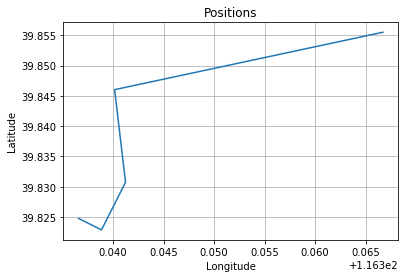

In [147]:
plt.plot(data['longitude'][:5], data['latitude'][:5])
plt.title('Positions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

## TESTANDO PLOT MAPA 

In [5]:
import folium

In [6]:
map_osm = folium.Map(location=[39.91, 116.40])

In [6]:
folium.Marker([45.3288, -121.6625], popup='Mt. Hood Meadows').add_to(map_osm)
folium.Marker([39.82477, 116.33659], popup='Mt. Hood Meadows').add_to(map_osm)
folium.Marker([39.82287, 116.33886], popup='Mt. Hood Meadows').add_to(map_osm)
folium.Marker([39.83074, 116.34124], popup='Mt. Hood Meadows').add_to(map_osm)
folium.Marker([39.84603, 116.34016], popup='Mt. Hood Meadows').add_to(map_osm)
folium.Marker([39.85551, 116.36671], popup='Mt. Hood Meadows').add_to(map_osm)

In [7]:
map_osm.save('osm.html')

In [9]:
for point in data.values:
    folium.Marker([pi, data['longitude'][i]], popup=data.date_time[i]).add_to(map_osm)

In [10]:
map_osm.save('data_taxi.html')